In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp
from ADM1_class import ADM1_instance

In [ ]:
def Statistics(observed_data_x, observed_data_y, expected_data_x, expected_data_y, t_0 = 0, t_n = -1):
#observed is from simulation
    observed_data_x = np.array(observed_data_x) 
    observed_data_y = np.array(observed_data_y)

#expected is base truth
    expected_data_x = np.array(expected_data_x) 
    expected_data_y = np.array(expected_data_y)
    
#allow time-piecewise analysis
    t_0 = np.where(expected_data_x >= t_0)
    t0 = t_0[0][0]
    if t_n > 0:
        t_n = np.where(expected_data_x <= t_n)
        tn = t_n[0][-1]
    else:
        tn = len(expected_data_x) -1
    
#make and fill conatiners for timed indexes for: t_expected == t_observed
    observed_t_i = []
    expected_t_i = []
    for i in np.linspace(t0, tn, len(expected_data_x), dtype = int):
        
        d = np.where(observed_data_x == expected_data_x[i])
        expected_t_i.append(d[0][0]) 
        f = np.where(expected_data_x == observed_data_x[d[0][0]])
        observed_t_i.append(f[0][0])       
    
#Pearsons R and two tailed p, calculation
    r = sp.stats.pearsonr(expected_data_y[observed_t_i], observed_data_y[expected_t_i])

#RMSE calculation
    se = (expected_data_y[observed_t_i] - observed_data_y[expected_t_i])**2
    mse = se.sum() / len(observed_t_i)
    rmse = mse**0.5
    
#returns two-tailed p-value, pearsons correlation coeficient, rmse value between the data
    return r[1],  r[0], rmse

def dilution(instance, data_simulation, data_observation, t_simulation, t_observation):
    #other process producing baseline methane
    #simple dilution using a half sphere to compare the found concentration to the simulated concentration a distance away from the source
    #THIS IS ONLY USED FOR THE TIMESHIFT AND DISTANCE, NOT FOR THE MAGNITUDE ALTERATION, that function is legacy
    
    #MAgnitude shift based on overlaying the top of the two datasets, and calculating the distance this implies.
    v1 = instance.V_gas 
    c1 = data_simulation['P_ch4'].max() #amplitude of this data
    t_sim_temp = data_simulation[data_simulation['P_ch4'] == data_simulation['P_ch4'].max()].index.values
    c1_t = t_simulation[t_sim_temp]#time of maximum simulated data
    
    c2 = max(data_observation)# - min(data_observation) #amplitude of this data
    c2_t = t_observation[data_observation.index(max(data_observation))] #index of maximum observed data
    
    r = ((3 * c1 * v1) /( 8* np.pi * c2))**(1/3) #calculate distance based on half dome dilution [m]
    v2 = r**3 * 8/3 * np.pi #volume of second half sphere used to recalculate other gas concentrations [m^3]
     
    #time shift
    time_shift = abs(c1_t - c2_t) #this calculated the difference in time between the peaks of the observed and measured data
    
    new_data_simulation = data_simulation * (v1/v2) #calculate other gas concentrations
    
    return new_data_simulation, r, time_shift

def Monte_carlo(reactor, func, x_avr, x_std, sims, ref_x, ref_y):
    solutions = [] #p- value, pearsons correlation, root mean square error, distance between source and sensor
    shots = [] #initial conditions used, this is not saved
    
    #Monte Carlo error analysis    
    x_avr_np = np.array(x_avr)
    
    for i in range(sims):
        #pick new uncertain x members
        x_MC = (x_avr_np.transpose() + (x_std * np.random.randn(len(x_avr)))).transpose()
        shots.append(x_MC)
        
        #find new y values with new x this is specific for the ADM1 based function
        y_MC = func(reactor, ref_x, x_MC)
        solutions.append(y_MC)
        
        #feedback, this keeps the researcher sane and informed.
        print("run", i)
    
    #calculate mean and stdev of Monte Carlo results
    return solutions, np.array(shots)

def analyse(reactor, t, x):
    #this function is used to wrangle the variables into a format suitable for both the ADM1 class, and the statistical tests
    
    #set new numbers
    reactor.V_liq = x[-2]
    reactor.V_gas = x[-1]
    reactor.inital_states = pd.DataFrame(x_avr[:-2], index = reactor.initial_state.keys())

    #generate simulation results with the random initial conditions
    solution, gasses, t_sim = reactor.dyn_sim(t.max() + 5, resolution = 100, feedback = False) #generate results from simulation, [gCOD/L], [Bar], [days]
    
    #change unit of the gasses to ppbv under Mars atmosphere
    P_gasses = ['P_h2', 'P_ch4', 'P_H2S']
    advanced_gasses = gasses[P_gasses]
    advanced_gasses /= Mars_atmosphere[-1][-1] * 10e-9 #convert to ppbv
    
    #use the non-diluting dilution algorthm to find a distance and timeshift value
    data, r_dist, dt = dilution(reactor, advanced_gasses, CH4_observations, t_sim, t_rover)
    
    #find the statistical values needed to draw conclusions
    p, r_val, rmse = Statistics(np.array(t_sim.tolist())[:-1], np.array(advanced_gasses['P_ch4'].tolist()), (expected.loc['x'] + dt).round(2), expected.loc['y'])
    
    return p, r_val, rmse, r_dist

def parse_data_to_file(filename, results):
    #this method allows data to be added to a file. This enables multiple runs of the montecarlo analysis to be performed independantly of machine stability by offloading RAM usage into permanent storage.
    try:
        file_original = pd.read_csv(filename)
        file = file_original.append(results, ignore_index=True)
        print("Filename found, appending.")
        
    except:  
        file = results
        print("No file found, creating new file.")
    
    file.to_csv((filename), index = False)
    

In [3]:
mars_instance = ADM1_instance(T_ad = 298.15, V_liq = 3400, V_gas = 300, p_atm = 1.013, q_ad = 0) #[K], [m^3], [m^3], [bar], [m^3/ d]

#Mars peak data from Giuranna et al. 2019
t_rover = [-1,0, 1, 8, 11, 13] #days
CH4_observations = [3, 5.78, 15.5, 2.13, 5, 5] #ppbv

#Trainer et al. 2019
Mars_atmosphere = [['Co2', 'N2', 'Ar', 'O2', 'CO', 'P'],[0.951, 0.0259, 0.0194, 0.0016, 0.008]]
expected = pd.DataFrame([np.array(t_rover) , CH4_observations], ['x', 'y'])

#define montecarlo avarages in an array
x_avr = mars_instance.initial_state.transpose().iloc[:,0].to_list()[:]
x_avr.append(mars_instance.V_liq)
x_avr.append(mars_instance.V_gas)

#define standart deviation as 1/3th the magnitude of the avarage
x_std = np.array(x_avr) / 4

In [5]:
#start analysis
#do 'sims' *20 iterations of the ADM1 simulation with different initial values, and write the reults to 'file_name'
file_name = "results_correlation_2.csv"

sims = 14 # * 20 simulations
for i in range(sims):
    ans = Monte_carlo(mars_instance, analyse, x_avr, x_std, 20, expected.loc['x'], expected.loc['y'])
    results = pd.DataFrame(ans[0], columns =['p_value', 'correlation', 'rmse', 'r'])
    parse_data_to_file(file_name, results)

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
Filename found, appending.
run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
Filename found, appending.
run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
Filename found, appending.
run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
Filename found, appending.
run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
Filename found, appending.
run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
Filename found, appending.
run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 

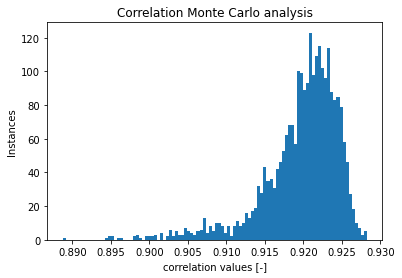

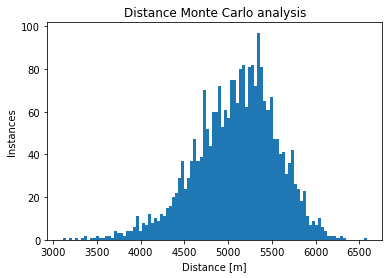

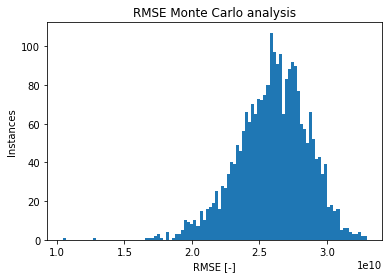

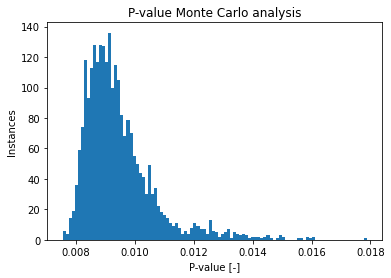

In [24]:
data = pd.read_csv(file_name)

#Fisher combination
#a = np.log(data.p_value[:])
#b = a.sum()*-2
#c = sp.chi2.pdf(b, 2*(len(a)))
#print(c, "p-value from fisher combination of p-values")


plt.figure()
plt.title("Correlation Monte Carlo analysis")
plt.ylabel("Instances")
plt.xlabel("correlation values [-]")
a = plt.hist(data.correlation, bins = 100)
#plt.savefig(f'ADM1_MC_Corr.png')

plt.figure()
plt.title("Distance Monte Carlo analysis")
plt.ylabel("Instances")
plt.xlabel("Distance [m]")
a = plt.hist(data.r, bins = 100)
#plt.savefig(f'ADM1_MC_dist.png')

plt.figure()
plt.title("RMSE Monte Carlo analysis")
plt.ylabel("Instances")
plt.xlabel("RMSE [-]")
a = plt.hist(data.rmse, bins = 100)
#plt.savefig(f'ADM1_MC_rmse.png')

plt.figure()
plt.title("P-value Monte Carlo analysis")
plt.ylabel("Instances")
plt.xlabel("P-value [-]")
a = plt.hist(data.p_value, bins = 100)
#plt.savefig(f'ADM1_MC_pval.png')